# Laboratorio 2
Este laboratorio se divide dentro de 3 tasks diferentes. El primer task se encuentra dentro del archivo Informe.pdf, dónde se respondieron preguntas teóricas sobre diferentes modelos / algoritmos aplicados en situaciones de la vida real.

Para los siguientes dos tasks, primero debemos descargar un dataset y limpiar los datos. Luego, debemos implementar algoritmos de ML desde 0 para aplicarlos sobre los datos limpios.

## Prompts
Cumpliendo con las reglas del laboratorio, utilicé IA generativa para generar las gráficas con Matplotlib / Seaborn. Los prompts consisten en:

[Contexto] Eg. I have a weight vector w_final, a bias b_final, and two DFs of training values x_train and y_train.

[Task] Eg. I need to graph the 2D points from x_train colored by y_train (binary classification) as there's going to be concentric points. Then, I'll need to graph the decision boundary for the model on top of it.

Esto funciona porque se explica al inicio los objetos con los que se están trabajando, así se evitan errores de compatibilidad etc. Adicionalmente, siendo descriptivos y concretos con el task se deja poca "interpretabilidad" donde la IA pueda tomar alguna decisión "tonta".

Adicionalmente, al ir iterando busco ser lo más específico posible con los objetos que se están trabajando o dar alguna guía lo más "bajo nivel posible". Por ejemplo,

"I'll need the plot to fill the background above / under the decision threshold to identify the positive / negative class, no other changes"

También, como preferencia personal hago la mayoría de cosas "a manita" pero ocupo la ayuda ocasional para recordar sintaxis / documentación. No pretendo que conozco todas las operaciones de álgebra lineal de Numpy, pero colocar un prompt dónde pregunto "cómo se calculaban normas en Numpy" se me hace un poco overkill :)

## Task 2

### 1. Carga y Limpieza
Primero, vamos a utilizar Kagglehub para poder descargar el dataset. De esta manera, al correr el Notebook en algún otro dispositivo no debemos estar manejando la transferencia del archivo .csv

In [274]:
import kagglehub
import pandas as pd
import numpy as np

path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

df = pd.read_csv(f"{path}/dataset_phishing.csv")

df.head(20)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
5,http://appleid.apple.com-app.es/,32,24,0,3,1,0,0,0,0,...,1,1,1,0,-1,0,0,1,0,phishing
6,http://www.mutuo.it,19,12,0,2,0,0,0,0,0,...,0,1,0,170,7529,0,0,0,1,legitimate
7,http://www.shadetreetechnology.com/V4/validati...,81,27,1,2,0,0,0,0,0,...,1,0,0,76,5767,0,0,1,2,phishing
8,http://vamoaestudiarmedicina.blogspot.com/,42,34,0,2,0,0,0,0,0,...,1,1,0,371,7298,0,0,0,5,legitimate
9,https://parade.com/425836/joshwigler/the-amazi...,104,10,0,1,10,0,0,0,0,...,1,0,0,128,9368,6774,0,0,5,legitimate


Luego de haber cargado exitosamente el dataset, lo primero que podemos observar es que tenemos 89 columnas. Sería ideal si tuviéramos alguna documentación sobre el significado de cada una, sin embargo, la descripción oficial del dataset es la siguiente:

"The provided dataset includes 11430 URLs with 87 extracted features. The dataset is designed to be used as benchmarks for machine learning-based phishing detection systems. Features are from three different classes: 56 extracted from the structure and syntax of URLs, 24 extracted from the content of their correspondent pages, and 7 are extracted by querying external services. The dataset is balanced, it contains exactly 50% phishing and 50% legitimate URLs."

Para el scope de este laboratorio, únicamente debemos indagar sobre las variables más correlacionadas con la variable objetivo. Por lo tanto, vamos a iniciar encodeando la variable objetivo.

In [275]:
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

status_counts = df['status'].value_counts().reset_index()

status_counts.columns = ['Status Label', 'Total Count']

status_counts

,Status Label,Total Count
0,0,5715
1,1,5715


Estos valores concuerdan con la descripción, dónde el dataset se encuentra perfectamente balanceado.

Ahora, podemos remover la columna de url, ya que tenemos una gran cantidad de atributos derivados numéricos. Luego, podemos identificar que columnas no tienen tipos de datos numéricos en el dataset restante.

In [276]:
df = df.drop(columns=['url'])

no_num = df.select_dtypes(exclude=['number']).columns.tolist()

print("Columnas no numéricas:")
print(no_num)

Columnas no numéricas:
[]


### 2. Selección de Features

Luego de verificar que todas las columnas sean numéricas, podemos calcular la correlación con la variable objetivo.

In [277]:
top = df.corr()['status'].abs().sort_values(ascending=False)[1:6]

top.to_frame('Correlation')

,Correlation
google_index,0.731171
page_rank,0.511137
nb_www,0.443468
ratio_digits_url,0.356395
domain_in_title,0.342807


Podemos ver que las dos variables más correlacionadas claramente son `google_index` y `page_rank`, por lo cuál serán las variables con las que trabajaremos. Podemos seleccionar unicamente las variables que nos interesan del DF.

In [278]:
df = df[['google_index', 'page_rank','status']]

df.head(10)

,google_index,page_rank,status
0,1,4,0
1,1,2,1
2,1,0,1
3,0,3,0
4,0,6,0
5,1,0,1
6,0,1,0
7,1,2,1
8,0,5,0
9,0,5,0


### 3. Split Test / Train
En el laboratorio se encuentran en otro orden los incisos, sin embargo si escalamos las variables antes de realizar la division tendriamos data leakage. Vamos a realizar un split estratificado respecto a la variable objetivo, 80/20 train/test.

In [279]:
from sklearn.model_selection import train_test_split

x = df.drop('status', axis=1)
y = df['status']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.20, 
    random_state=42,
    stratify=y
)

In [280]:
x_train

,google_index,page_rank
7609,1,6
6408,1,0
7464,1,3
9286,1,7
5159,1,3
...,...,...
8364,0,5
9876,1,0
4943,1,5
9054,1,0


### 4. Feature Scaling
Antes de escalar los features, nos interesa saber la distribucion de los datos. Antes que nada, debemos de buscar los posibles valores de cada una de nuestras variables:

In [281]:
print('Google Index unique values')
print(df['google_index'].unique())

print('Page rank unique values')
print(f"Sample values: {df['page_rank'].unique()}")

Google Index unique values
[1 0]
Page rank unique values
Sample values: [ 4  2  0  3  6  1  5  7  8 10  9]


Podemos ver que Google Index corresponde a una clasificacion binaria, entonces podemos proceder a examinar la distribucion de Page Rank

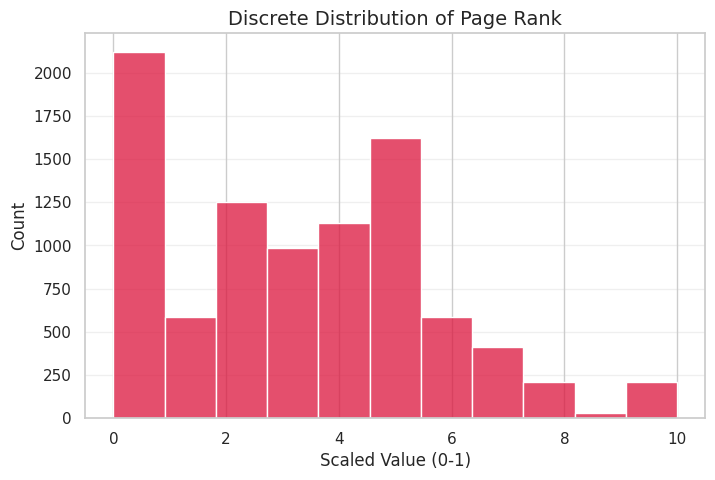

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.histplot(x=x_train['page_rank'], color='crimson', bins=11, kde=False)

plt.title('Discrete Distribution of Page Rank', fontsize=14)
plt.xlabel('Scaled Value (0-1)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

Claramente, la distribucion no parece seguir una distribucion normal. De hecho, pareciera seguir una distribucion multimodal (lo cual tiene sentido, ya que esta correlacionada con la variable objetivo). Esto nos indica que la mejor opcion para utilizar el MinMax Scaler, ademas tenemos la ventaja que nuestro otro feature ya se encuentra en el rango [0,1].

Adicionalmente, podemos observar en la distribucion que tenemos una cola bastante larga hacia la derecha. Podemos examinar algunos de estos valores mas a detalle, buscando que los valores atipicos en la cola derecha no 'apachen' o 'estiren' nuestros datos

In [283]:
import pandas as pd

percentiles = [.9, .95, .96, .97, .98, .99]

stats_df = x_train[['page_rank']].describe(percentiles=percentiles).T

cols_to_show = ['90%', '95%', '96%', '97%', '98%', '99%', 'max']

stats_df = stats_df[cols_to_show]

stats_df

,90%,95%,96%,97%,98%,99%,max
page_rank,6.0,7.0,8.0,8.0,10.0,10.0,10.0


Podemos ver que los datos por encima de 8 empiezan a 'aplanarse' un poco respecto al percentil, ademas representan una fraccion relativamente pequeña de neustros datos. Por lo tanto, podemos poner un 'cap' a los datos con valores encima de 8. Adicionalmente, aplicamos nuestro MinMaxScaler().

In [284]:
from sklearn.preprocessing import MinMaxScaler

x_train['page_rank'], x_test['page_rank'] = x_train['page_rank'].clip(upper=8.0), x_test['page_rank'].clip(upper=8.0)

scaler = MinMaxScaler()

x_train['page_rank'] = scaler.fit_transform(x_train[['page_rank']])
x_test['page_rank'] = scaler.transform(x_test[['page_rank']])

Ahora, podemos ver nuestra nueva distribucion generando la gráfica original nuevamente.

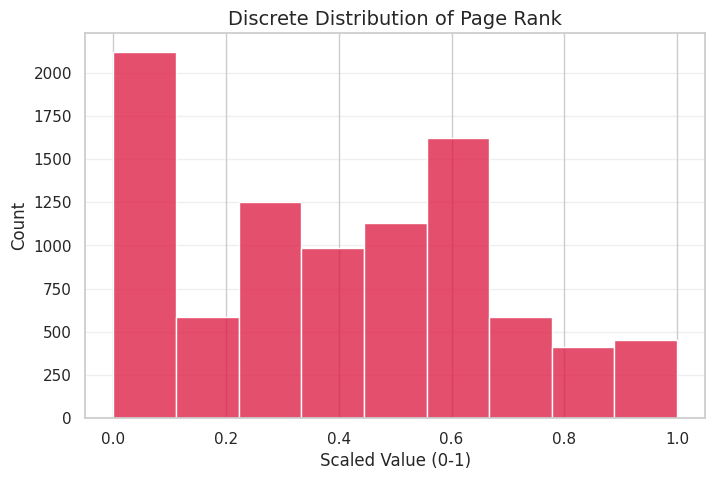

In [285]:
plt.figure(figsize=(8, 5))

sns.histplot(x=x_train['page_rank'], color='crimson', bins=9, kde=False)

plt.title('Discrete Distribution of Page Rank', fontsize=14)
plt.xlabel('Scaled Value (0-1)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

Ya que ahora tenemos los valores escalados en el intervalo necesario y realizamos ajustes a los valores máximos, tenemos nuestro dataset listo para modelar.

## Task 3

### Regresión Logística con Descenso de Gradiente

**1. Función Sigmoide y Predicción**

In [286]:
# Función Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Predicción utilizando X (matriz de valores), w (pesos) y b (bias)
def predict(X, w, b):
    # Las predicciones 'lineales' son Xw + b
    z = np.dot(X, w) + b

    # Se calcula la sigmoide de las predicciones
    return sigmoid(z)

**2. Log Loss / Binary Cross-Entropy**

In [287]:
# Función Log Loss
def log_loss(X, y, w, b):

    # m es la cantidad de observaciones
    m = X.shape[0]

    # y pred son todas las predicciones sobre nuestros datos en X
    y_pred = predict(X, w, b)

    # Limitar valores a 0.00000...1 y 0.999... para evitar errores 
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

    # Si y = 1, tomamos log(pred). Si y = 0, tomamos log(1-pred)
    # Luego promediamos
    cost = -(1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    return cost

**3. Gradient Descent**

In [288]:
# Función de entrenamiento utilzando descenso de gradiente
def train(X, y, w, b, learning_rate, epochs):

    # m es la cantidad de observaciones
    m = X.shape[0]

    # Creamos una lista para almacenar resultados históricos
    cost_history = []

    # Para cada épóca
    for i in range(epochs):

        # Realizar predicciones
        y_pred = predict(X, w, b)
        
        # El vector error = predicciones - real
        error = y_pred - y

        # Derivada parcial respecto al bias es el error promedio
        db = (1 / m) * np.sum(error)

        # Derivada parcial respecto a los pesos es producto punto entre Features y Error
        dw = (1 / m) * np.dot(X.T, error)
        
        # Actualizamos los pesos utilizando su derivada parcial
        w = w - learning_rate * dw

        # Actualizamos el bias utilizando su derivada parcial
        b = b - learning_rate * db
        
        # Calculamos el loss y lo guardamos
        cost = log_loss(X, y, w, b)
        cost_history.append(cost)
        
        # Imprimir cada 100 épocas (se necesitan bastantes para converger)
        if i % 100 == 0:
            print(f"Época {i}: Costo {cost:.4f}")
            
    return w, b, cost_history

**Entrenamiento de Modelo**

In [289]:
# Convertir a arrays de Numpy por eficiencia
X = x_train.values
X_test_arr = x_test.values

# Reshape de y hacia una columna, si es una lista "plana" ya no funciona
y = y_train.values.reshape(-1, 1)
y_test_arr = y_test.values.reshape(-1, 1)

# Inicializamos n pesos para n features en 0
num_features = X.shape[1]
w = np.zeros((num_features, 1))
b = 0.0

# Hiperparametros
learning_rate = 0.01
epochs = 25000

# Entrenamiento
w_final, b_final, cost_hist = train(X, y, w, b, learning_rate, epochs)

Época 0: Costo 0.6927
Época 100: Costo 0.6558
Época 200: Costo 0.6243
Época 300: Costo 0.5970
Época 400: Costo 0.5729
Época 500: Costo 0.5516
Época 600: Costo 0.5327
Época 700: Costo 0.5158
Época 800: Costo 0.5007
Época 900: Costo 0.4871
Época 1000: Costo 0.4749
Época 1100: Costo 0.4639
Época 1200: Costo 0.4539
Época 1300: Costo 0.4449
Época 1400: Costo 0.4367
Época 1500: Costo 0.4292
Época 1600: Costo 0.4224
Época 1700: Costo 0.4162
Época 1800: Costo 0.4105
Época 1900: Costo 0.4053
Época 2000: Costo 0.4005
Época 2100: Costo 0.3960
Época 2200: Costo 0.3919
Época 2300: Costo 0.3881
Época 2400: Costo 0.3846
Época 2500: Costo 0.3814
Época 2600: Costo 0.3783
Época 2700: Costo 0.3755
Época 2800: Costo 0.3729
Época 2900: Costo 0.3704
Época 3000: Costo 0.3681
Época 3100: Costo 0.3660
Época 3200: Costo 0.3640
Época 3300: Costo 0.3621
Época 3400: Costo 0.3603
Época 3500: Costo 0.3587
Época 3600: Costo 0.3571
Época 3700: Costo 0.3556
Época 3800: Costo 0.3542
Época 3900: Costo 0.3529
Época 4000: 

**Gráfica de Costo**

Text(0, 0.5, 'Costo (Error)')

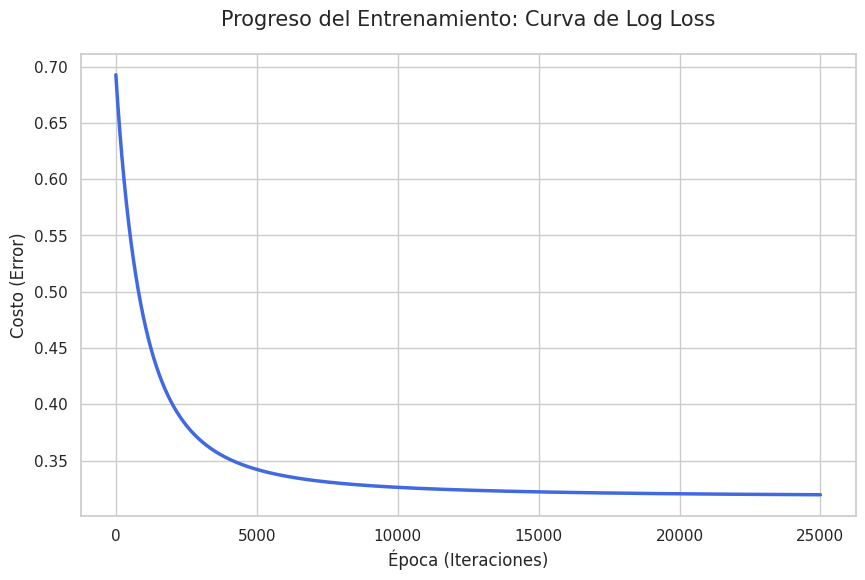

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(data=cost_hist, color="royalblue", linewidth=2.5)

plt.title('Progreso del Entrenamiento: Curva de Log Loss', fontsize=15, pad=20)
plt.xlabel('Época (Iteraciones)', fontsize=12)
plt.ylabel('Costo (Error)', fontsize=12)

**Decision Boundary**

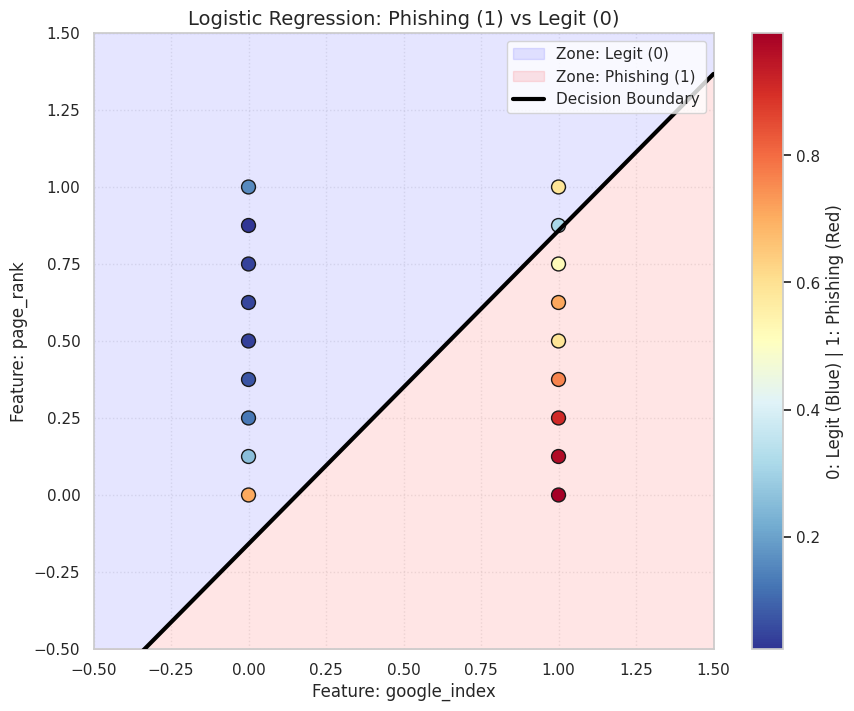

In [291]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = x_train.iloc[:, [0, 1]].copy()
plot_df['target'] = y_train.values
cols = plot_df.columns
piles = plot_df.groupby([cols[0], cols[1]])['target'].mean().reset_index()

plt.figure(figsize=(10, 8))

x_min, x_max = piles.iloc[:, 0].min() - 0.5, piles.iloc[:, 0].max() + 0.5
y_min, y_max = piles.iloc[:, 1].min() - 0.5, piles.iloc[:, 1].max() + 0.5
x_points = np.array([x_min, x_max])
y_points = -(w_final[0] * x_points + b_final) / w_final[1]

test_z = (w_final[0] * np.mean(x_points)) + (w_final[1] * y_max) + b_final

if test_z > 0:
    plt.fill_between(x_points, y_points, y_max, color='red', alpha=0.1, label='Zone: Phishing (1)')
    plt.fill_between(x_points, y_points, y_min, color='blue', alpha=0.1, label='Zone: Legit (0)')
else:
    plt.fill_between(x_points, y_points, y_max, color='blue', alpha=0.1, label='Zone: Legit (0)')
    plt.fill_between(x_points, y_points, y_min, color='red', alpha=0.1, label='Zone: Phishing (1)')

scatter = plt.scatter(piles.iloc[:, 0], piles.iloc[:, 1], s=100, 
                      c=piles['target'], cmap='RdYlBu_r', edgecolors='k', zorder=3)

plt.plot(x_points, y_points, color='black', linewidth=3, label='Decision Boundary', zorder=4)

plt.title("Logistic Regression: Phishing (1) vs Legit (0)", fontsize=14)
plt.xlabel(f"Feature: {cols[0]}")
plt.ylabel(f"Feature: {cols[1]}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.colorbar(scatter, label='0: Legit (Blue) | 1: Phishing (Red)')
plt.grid(True, linestyle=':', alpha=0.4)

plt.show()

### KNN
Para implementar KNN, hay un par de cosas que me di cuenta experimentando con el dataset:

- Tenemos pocos "hotspots" donde tenemos 500+ observaciones en un solo punto, entonces tendríamos que ver cómo "desempatar"
    - SKLearn desempata basado en los primeros que encuentra en la lista
    - En mi opinión, sería más justo tomar los puntos a una misma distancia y obtener un promedio para decidir. Esto a pesar del costo computacional más alto
- Hay algunos errores con la aritmética de punto flotante, hasta experimentando con SKLearn había situaciones dónde cambiando de un lado a otro (izquierda vs derecha) de un "hotspot" de puntos cambiaba la predicción.

Por lo tanto, estaré implementando una versión de KNN más "robusta" ante estos errores bajo mi propio criterio. Adicionalmente, para mantener la aritmética de punto flotante estaré implementanto un epsilon pequeño en las operaciones así evitando que un punto resulte "más lejano" por un error computacional.

Había grabado este [video](https://youtu.be/8wVeUttsh1A) para compartirlo con Suriano, me dió algunas recomendaciones pero no me dio tiempo de implementarlas

**KNN**

In [292]:
import numpy as np

# Margen para error de punto flotante
EPSILON = 1e-9

def predict_knn(X_train, y_train, X_test, k):
    # Calculamos distancia euclidiana
    dists = np.linalg.norm(X_train - X_test, axis=1)
    
    # Aplicamos Epsilon para redondear errores de precisión
    dists = np.round(dists / EPSILON) * EPSILON
    
    # Encontramos el radio del K vecino más lejano
    sorted_dists = np.sort(dists)
    dist_k = sorted_dists[k-1]
    
    # Tomamos todos los puntos dentro de ese radio
    mask = dists <= (dist_k + EPSILON)
    
    # Retornar el promedio (probabilidad)
    return np.mean(y_train[mask])

**Decision Boundary**

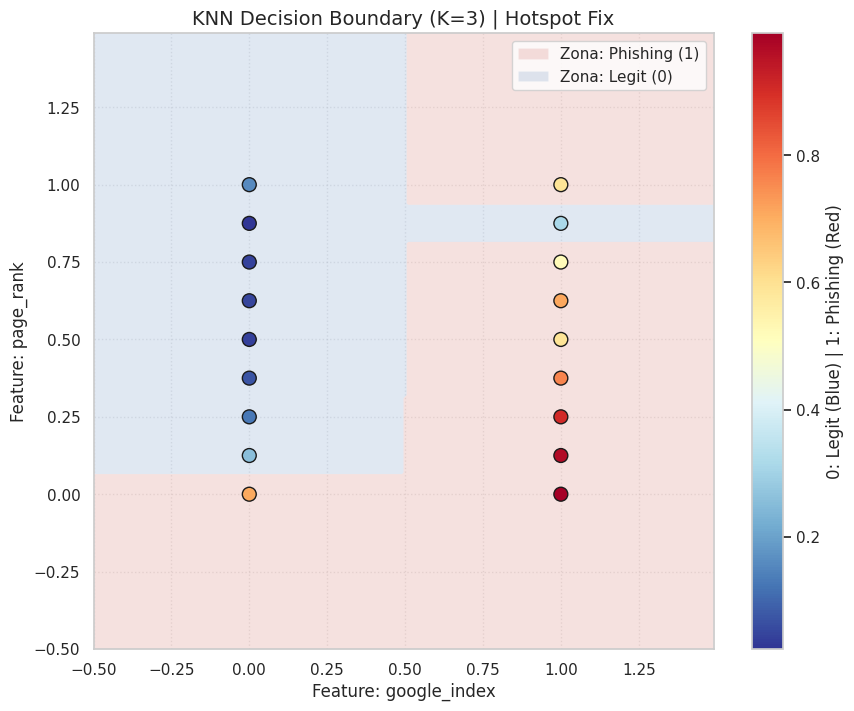

In [293]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plot_df = x_train.iloc[:, [0, 1]].copy()
plot_df['target'] = y_train.values
cols = plot_df.columns
piles = plot_df.groupby([cols[0], cols[1]])['target'].mean().reset_index()

X_train_np = x_train.iloc[:, [0, 1]].values
y_train_np = y_train.values

h = 0.01 
x_min, x_max = piles.iloc[:, 0].min() - 0.5, piles.iloc[:, 0].max() + 0.5
y_min, y_max = piles.iloc[:, 1].min() - 0.5, piles.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict_knn(X_train_np, y_train_np, pt, k=3) for pt in grid_points])
Z = Z.reshape(xx.shape)
Z_binary = (Z >= 0.5).astype(int)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z_binary, levels=[-0.5, 0.5, 1.5], 
             colors=['#3065AC', '#C0392B'], alpha=0.15, antialiased=True)

scatter = plt.scatter(piles.iloc[:, 0], piles.iloc[:, 1], s=100, 
                      c=piles['target'], cmap='RdYlBu_r', edgecolors='k', zorder=3)

plt.title(f"KNN Decision Boundary (K=3) | Hotspot Fix", fontsize=14)
plt.xlabel(f"Feature: {cols[0]}")
plt.ylabel(f"Feature: {cols[1]}")
plt.colorbar(scatter, label='0: Legit (Blue) | 1: Phishing (Red)')
plt.grid(True, linestyle=':', alpha=0.4)

legend_elements = [Patch(facecolor='#C0392B', alpha=0.15, label='Zona: Phishing (1)'),
                   Patch(facecolor='#3065AC', alpha=0.15, label='Zona: Legit (0)')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

**Decision Boundary + Predicciones**

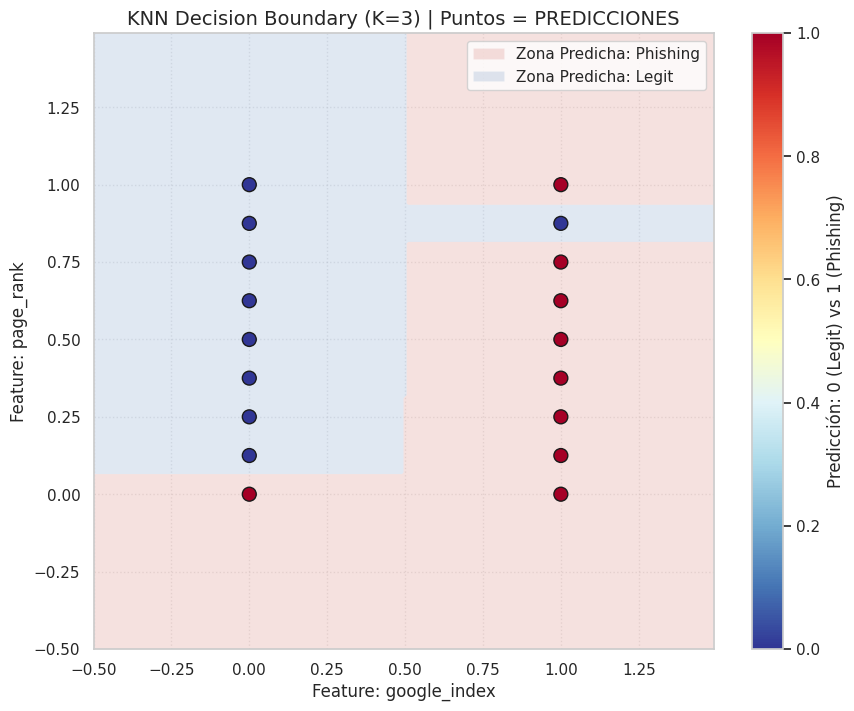

In [294]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

X_train_np = x_train.iloc[:, [0, 1]].values
y_train_np = y_train.values

plot_df = x_train.iloc[:, [0, 1]].copy()
plot_df['target'] = y_train.values
cols = plot_df.columns
piles = plot_df.groupby([cols[0], cols[1]])['target'].mean().reset_index()
coords_to_predict = piles.iloc[:, [0, 1]].values

y_piles_pred = np.array([predict_knn(X_train_np, y_train_np, pt, k=3) for pt in coords_to_predict])
y_piles_pred_binary = (y_piles_pred >= 0.5).astype(int)

h = 0.01 
x_min, x_max = piles.iloc[:, 0].min() - 0.5, piles.iloc[:, 0].max() + 0.5
y_min, y_max = piles.iloc[:, 1].min() - 0.5, piles.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict_knn(X_train_np, y_train_np, pt, k=3) for pt in grid_points])
Z_binary = (Z.reshape(xx.shape) >= 0.5).astype(int)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z_binary, levels=[-0.5, 0.5, 1.5], 
             colors=['#3065AC', '#C0392B'], alpha=0.15, antialiased=True)

scatter = plt.scatter(piles.iloc[:, 0], piles.iloc[:, 1], s=100, 
                      c=y_piles_pred_binary, cmap='RdYlBu_r', edgecolors='k', zorder=3)

plt.title(f"KNN Decision Boundary (K=3) | Puntos = PREDICCIONES", fontsize=14)
plt.xlabel(f"Feature: {cols[0]}")
plt.ylabel(f"Feature: {cols[1]}")
plt.colorbar(scatter, label='Predicción: 0 (Legit) vs 1 (Phishing)')
plt.grid(True, linestyle=':', alpha=0.4)

legend_elements = [Patch(facecolor='#C0392B', alpha=0.15, label='Zona Predicha: Phishing'),
                   Patch(facecolor='#3065AC', alpha=0.15, label='Zona Predicha: Legit')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

## Task 4

### Benchmark

**KNN**

In [295]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Antes, vamos a realizar un shuffle 
knn_sk = KNeighborsClassifier(n_neighbors=3).fit(X, y.ravel())
y_pred_sk_knn = knn_sk.predict(X)

y_pred_custom_knn = np.array([predict_knn(X, y.ravel(), pt, k=3) for pt in X])
y_pred_custom_knn = (y_pred_custom_knn >= 0.5).astype(int)

print("KNN CUSTOM")
print(classification_report(y, y_pred_custom_knn))

print("\nKNN SKLEARN")
print(classification_report(y, y_pred_sk_knn))

KNN CUSTOM
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      4572
           1       0.85      0.93      0.89      4572

    accuracy                           0.88      9144
   macro avg       0.89      0.88      0.88      9144
weighted avg       0.89      0.88      0.88      9144


KNN SKLEARN
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4572
           1       0.88      0.79      0.83      4572

    accuracy                           0.84      9144
   macro avg       0.85      0.84      0.84      9144
weighted avg       0.85      0.84      0.84      9144



Podemos ver que en este caso, la implementación custom de KNN fue superior a la de SKLearn. Especialmente en cuánto a las métricas que más nos interesan (en los últimos incisos se cubre el por qué) como Recall de la clase positiva. En cuánto a los atributos macro, la diferencia no parece ser mucha. Sin embargo, echando un vistazo a los valores de Recall para cada uno de los modelos podemos ver que SKLearn principalmente predice que los sitios web son seguros mientras que nuestro modelo predice lo contrario. Esto resalta la importancia de observar métricas a parte de únicamente "overviews" cómo lo pueden ser macro F1 o weighed F1.


También tenemos que tomar en cuenta, que nuestro modelo de KNN fue desarrollado con este problema específico en mente. Dónde fueron observados los puntos y se pudo observar el problema de tener múltiples puntos equidistantes. Para algunos otros problemas, cómo algunos que involucren variables continuas el modelo de SKLearn sigue siendo superior. Esto ya que fue computacionalmente más eficiente, y el problema de los múltiples puntos concéntricos probablemente no se presente.

**Logistic Regression**

In [296]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

log_reg_sk = LogisticRegression().fit(X, y.ravel())
y_pred_sk_log = log_reg_sk.predict(X)

z_custom = np.dot(X, w_final) + b_final
y_pred_custom_log = (1 / (1 + np.exp(-z_custom)) >= 0.5).astype(int)

print("LR Custom")
print(classification_report(y, y_pred_custom_log))

print("LR SKLearn")
print(classification_report(y.ravel(), y_pred_sk_log))

LR Custom
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4572
           1       0.87      0.87      0.87      4572

    accuracy                           0.87      9144
   macro avg       0.87      0.87      0.87      9144
weighted avg       0.87      0.87      0.87      9144

LR SKLearn
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4572
           1       0.87      0.87      0.87      4572

    accuracy                           0.87      9144
   macro avg       0.87      0.87      0.87      9144
weighted avg       0.87      0.87      0.87      9144



Aquí podemos ver que los resultados fueron idénticos, en este caso la implementación de descenso de gradiente fue lo suficientemente robusta para tener los resultados deseados. Sin embargo, también debemos de tomar en cuenta que al tener múltiples puntos discretos (16 hotspots en este caso) nuestro decision boundary tiene un margen de error bastante grande. Es decir, si subiéramos el bias ligeramnete (0.1 por ejemplo) es posible que siguiésemos "cortando" la gráfica de manera idéntica.

### Análisis de Cierre

a. En la regresión logística los resultados fueron idénticos, dado que tenemos 16 posibles valores. Esto quiere decir que podemos cambiar los pesos ligeramente y seguir cortando la gráfica de la misma manera. En KNN, la implementación "equitativa" mostró ser superior, esto porque se observó el problema y se planteo una solución a una posible limitante de un algoritmo ya existente. Sin embargo, tomando costos computacionales en cuenta la implementación de SKLearn sigue siendo bastante efectiva.

b. En mi opinión, el falso negativo es más peligroso que el falso positivo. En un setting de oficina, un FP interrumpe el flujo de trabajo al obligar al empleado a envíar un ticket a IT para solucionar el problema. Mientras que con un FN, el usuario puede cargar sus credenciales dentro de un formulario falso y conceder acceso a cualquier tipo de sistema delicado. Deberíamos de priorizar Recall.